In [1]:
# 1. Importing Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', None)

import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

import math
from collections import Counter
import scipy.stats as ss
from scipy.stats import pearsonr

## All feature engg in a single cell for ease

In [2]:
df = pd.read_csv('ABC_payments_bank_credcard_train.csv')

# TRANSFORMATION CODE FROM EDA
# 1. DELETING USER ID
del df["user_id"]

# 2. AGE FROM DOB
from datetime import datetime, date


def age(born):
    born = datetime.strptime(born, "%d/%m/%Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, 
                                      today.day) < (born.month, 
                                                    born.day))
  
df['Age'] = df['date_of_birth'].apply(age)
df['log_age'] = np.log(df['Age'])

# 3. AGE GROUP FROM AGE
df['age_group'] = pd.cut(df.Age, bins=[0,25,35,45,55,65,75,99], labels =['0-25','25-35','35-45','45-55','55-65','65-75','75-99'])

# 4. STATE, city AND ZIPCODE FROM ADRESS
df['zipcode'] = df['address'].str[-5:]
df['state'] = df['address'].str[-8:-6]
def city_name(t):
    s=t.find('\n')
    e=t.find(',')
    return t[s+1:e]

df['city']=df.address.apply(city_name)

# 5. Extracting domain and DELETING EMAIL
def email_domain(t):
    words=t.split("@")
    domain_name=words[1]
    domain=domain_name.split('.')[0]
    return domain
df['email_domain']=df.email.apply(email_domain)
del df['email']

# 6. EDUCATINO GROUPS
df['edu_group'] = pd.cut(df.education_num, bins=[0,2,6,8,10,12,13,14,17], labels =['pre','matri','hs','diplo','asso','grad','pg','phd'])

# 7. hours group
df['hours_group'] = pd.cut(df.hours_per_week,bins=[0,10,20,30,35,40,45,50,55,60,70,99], labels=['0-10','10-20','20-30','30-35','35-40','40-45','45-50','50-55','55-60','60-70','70-99'])
df['log_hours'] = np.log(df['hours_per_week'])

# 8. Imputing asset_class_cd
df["asset_class_cd"].fillna("-1", inplace = True)

def change(value):
    if value == '1':
        value = 'S'
    return value
        
df['asset_class_cd'] = df['asset_class_cd'].apply(change)


# 9. Transforming cap_gain to grp
df['cap_gain_grp'] = pd.cut(df['capital_gain'], bins = [-1,3100,6850,100000], labels = ['low','mid','high'])

df['cap_loss_grp'] = pd.cut(df['capital_loss'], bins = [-1,1800,27000,100000], labels = ['low_loss','mid_loss','high_loss'])

df['net_cap_gain'] = df['capital_gain']-df['capital_loss']

#df['net_cap_grp_log'] = pd.cut(np.log(df['net_cap_gain'])**3, bins = [-1,576,689,1300], labels = ['low_net_gain','mid_net_gain','high_net_gain'])

df['cap_gain_pow3'] = pd.cut((df['capital_gain']**3), bins = [-1,46908800,1000000000000000], labels = ['low','high'])



## RELATIONSHIP ADDITIONAL COLUMN
def grouping_relationship(t):
    if t == ' Husband' or t== ' Wife':
        return 1
    else:
        return 0    
df['husb_or_wife'] = df['relationship'].apply(grouping_relationship)



## INQUIRY_PURPOSE_CODE ADDITIONAL COLUMN
def grouping_iq(t):
    if t == 7:
        return 1
    else:
        return 0
df['inquiry_is_seven'] = df.inquiry_purpose_code.apply(grouping_iq)



## OCCUPATION GROUPING
def grouping_occ(t):
    if t == ' Exec-managerial' or t == ' Prof-specialty':
        return 'a'
    elif t == ' Sales' or t== ' Transport-moving' or t== ' Tech-support' or t== ' Protective-serv' or t== ' Craft-repair' or t== ' Armed-Forces':
        return 'b'
#    elif t== ' Adm-clerical' or t == ' Farming-fishing' or t== ' Machine-op-inspct' or t== ' Handlers-cleaners' or t== ' Other-service':
    else:
        return 'c'
df['occupation_grp'] = df.occupation.apply(grouping_occ)



# TEST SET AND TRAIN SET
df_train = df.sample(frac=0.8, random_state = 25)
df_test = df.drop(df_train.index)


# 9. Imputing inquiry purpose code
df_train['inquiry_purpose_code'] = df_train['inquiry_purpose_code'].fillna(df_train['inquiry_purpose_code'].mode()[0])
df_test['inquiry_purpose_code'] = df_test['inquiry_purpose_code'].fillna(df_train['inquiry_purpose_code'].mode()[0])

#10. Imputing asset code
df_train['asset_code'] = df_train['asset_code'].fillna(df_train['asset_code'].mode()[0])
df_test['asset_code'] = df_test['asset_code'].fillna(df_train['asset_code'].mode()[0])

#11. Imputation portfolio type
df_train['portfolio_type'] = df_train['portfolio_type'].fillna(df_train['portfolio_type'].mode()[0])
df_test['portfolio_type'] = df_test['portfolio_type'].fillna(df_train['portfolio_type'].mode()[0])

df_train['inquiry_purpose_code'] = df_train.inquiry_purpose_code.astype('category')
df_train['institute_type'] = df_train.institute_type.astype('category')
df_train['account_type'] = df_train.account_type.astype('category')
df_train['asset_class_cd'] = df_train.asset_class_cd.astype('object')
df_train['asset_code'] = df_train.asset_code.astype('object')
df_train['portfolio_type']= df_train.portfolio_type.astype('object')
df_train['hours_group']= df_train.hours_group.astype('object')


df_test['inquiry_purpose_code']=df_test.inquiry_purpose_code.astype('object')
df_test['institute_type']=df_test.institute_type.astype('object')
df_test['account_type']=df_test.account_type.astype('object')
df_test['asset_class_cd']=df_test.asset_class_cd.astype('object')
df_test['asset_code']=df_test.asset_code.astype('object')
df_test['portfolio_type']=df_test.portfolio_type.astype('object')
df_test['hours_group']= df_test.hours_group.astype('object')
df_train1 = df_train
df_test1 = df_test

## Important functions used

In [3]:
# New data function to find percentages of different categories without target variable
def perc_without_target(feature):
    new_df = df[feature].value_counts(normalize=True)
    new_df = new_df.mul(100).rename('Percent').reset_index()
    return new_df

In [4]:
# New data function to find percentages of different categories with target variable
def perc_with_target(feature,target):
    new_df = df.groupby(feature)[target].value_counts(normalize=True)
    new_df = new_df.mul(100).rename('Percent').reset_index()
    return new_df

In [5]:
def plotting_percentages_plotly(df, col, target):

    # Creates a temporary dataframe to get the percentages
    temp_df = df.groupby(col)[target].value_counts(normalize=True)
    temp_df = temp_df.mul(100).rename('Percent').reset_index()
    temp_df['Percent'] = temp_df['Percent'].round(decimals=1)

    # Plot the percentages with the temporary dataframe
    fig = px.bar(temp_df, x=col, y='Percent', color=target, 
                    barmode="overlay", text='Percent', title=f"Percent {target} By {col}")

    return fig
# barmode: group,stac,relative,overlay

In [6]:

def plotting_percentages_sbn(df, col, target):
    x, y = col, target
    
    # Temporary dataframe with percentage values
    temp_df = df.groupby(x)[y].value_counts(normalize=True)
    temp_df = temp_df.mul(100).rename('percent').reset_index()

    # Sort the column values for plotting    
    order_list = list(df[col].unique())
    order_list.sort()

    # Plot the figure
    sns.set(font_scale=1.5)
    g = sns.catplot(x=x, y='percent', hue=y,kind='bar', data=temp_df, 
                    height=8, aspect=2, order=order_list, legend_out=False)
    g.ax.set_ylim(0,100)

    # Loop through each bar in the graph and add the percentage value    
    for p in g.ax.patches:
        txt = str(p.get_height().round(1)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
        
    # Set labels and title
    plt.title(f'{col.title()} By Percent {target.title()}', 
              fontdict={'fontsize': 30})
    plt.xlabel(f'{col.title()}', fontdict={'fontsize': 20})
    plt.ylabel(f'{target.title()} Percentage', fontdict={'fontsize': 20})
    plt.xticks(rotation=75)
    return g

In [7]:

def without_hue(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

# Functions for models

In [8]:
import category_encoders as ce
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold, cross_validate, cross_val_predict

from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif


from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import  plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix
    
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [9]:
def label_encoding(df):
    
    enc_lab = ce.OrdinalEncoder(return_df=True)
    df = enc_lab.fit_transform(df)
    return df, enc_lab

In [10]:
def one_hot_encoding(col):

    length = len(df_train[col])
    df_net = df_train[col].merge(df_test[col])
    df_net = pd.get_dummies(df_net)
    
    df_1_one = df_net[:length]
    df_2_one = df_net[length:]
    df_2_one = df_2_one.reindex(columns = df_1_one.columns, fill_value=0)
    return df_1_one, df_2_one

In [11]:
def target_encoding(df_to_enc):
    
    enc_tar = ce.TargetEncoder(smoothing = 85) 
    df_enc = enc_tar.fit_transform(df_to_enc, df_train['approved'])
    return df_enc, enc_tar

In [12]:
sc = StandardScaler()
nc = Normalizer()

In [34]:
def models(x,y, x_test, y_test):

#     # split data into train and test sets
#     #x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size= 0.2)
#     # TO BE CHECKED cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
#     #XG-BOOST
    model_xgb = XGBClassifier()
    model_xgb.fit(x, y)
    y_pred_train = cross_val_predict(model_xgb, x, y, cv= 5)    
    y = y.to_numpy().reshape((-1,1))
    y_pred_train = y_pred_train.reshape((-1,1))
    print('\n \n FOR XGBOOST')
    print('roc_auc_score for training is', metrics.roc_auc_score(y,y_pred_train))
    print('precision for training is',metrics.precision_score(y,y_pred_train), '\n Recall for training is',metrics.recall_score(y,y_pred_train),'\n f1_score is', metrics.f1_score(y,y_pred_train))
    # for test set
    y_test = y_test.to_numpy().reshape((-1,1))
    y_pred_test = model_xgb.predict(x_test)
    y_pred_test = y_pred_test.reshape((-1,1))
    plot_confusion_matrix(model_xgb, x_test, y_test)  
    plt.show()
    print('roc_auc_score for test is', metrics.roc_auc_score(y_test,y_pred_test),'\n precision for test is',metrics.precision_score(y_test,y_pred_test), '\n recall for test is',metrics.recall_score(y_test,y_pred_test),'\n f1_score is', metrics.f1_score(y_test,y_pred_test))
    
#     # LOGISTIC REGRESSION
#     model_logr = LogisticRegression()
#     model_logr.fit(x, y)
#     y_pred_train = cross_val_predict(model_logr, x, y, cv= 5)
#     y_pred_train = y_pred_train.reshape((-1,1))
#     print('\n \n FOR LOGISTIC REGRESSION')
#     print('\n roc_auc_score for training is', metrics.roc_auc_score(y,y_pred_train))
#     print('precision for training is',metrics.precision_score(y,y_pred_train), '\n Recall for training is',metrics.recall_score(y,y_pred_train),'\n f1_score is', metrics.f1_score(y,y_pred_train))
#     # for test set
#     y_pred_test = model_logr.predict(x_test)
#     y_pred_test = y_pred_test.reshape((-1,1))
#     plot_confusion_matrix(model_logr, x_test, y_test)  
#     plt.show()
#     print('roc_auc_score for test is', metrics.roc_auc_score(y_test,y_pred_test),'\n precision for test is',metrics.precision_score(y_test,y_pred_test), '\n recall for test is',metrics.recall_score(y_test,y_pred_test),'\n f1_score is', metrics.f1_score(y_test,y_pred_test))
    

    
    
#     # RANDOM FOREST
#     model_RF = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', random_state = 0)
#     model_RF.fit(x, y)
#     y_pred_train = cross_val_predict(model_RF, x, y, cv= 5)
#     y_pred_train = y_pred_train.reshape((-1,1))
#     print('\n \n FOR RANDOM FOREST')
#     print('roc_auc_score for training is', metrics.roc_auc_score(y,y_pred_train))
#     print('precision for training is',metrics.precision_score(y,y_pred_train), '\n Recall for training is',metrics.recall_score(y,y_pred_train),'\n f1_score is', metrics.f1_score(y,y_pred_train))
#     # for test set
#     y_pred_test = model_RF.predict(x_test)
#     y_pred_test = y_pred_test.reshape((-1,1))
#     plot_confusion_matrix(model_RF, x_test, y_test)  
#     plt.show()
#     print('roc_auc_score for test is', metrics.roc_auc_score(y_test,y_pred_test),'\n precision for test is',metrics.precision_score(y_test,y_pred_test), '\n recall for test is',metrics.recall_score(y_test,y_pred_test),'\n f1_score is', metrics.f1_score(y_test,y_pred_test))
   

    # LIGHT BGM
    model_lgbm = LGBMClassifier()
    model_lgbm.fit(x, y)
    y_pred_train = cross_val_predict(model_lgbm, x, y, cv= 5)
    y_pred_train = y_pred_train.reshape((-1,1))
    #y_test = y_test.to_numpy().reshape((-1,1))
    #y = y.to_numpy().reshape((-1,1))
    print('\n \n FOR LIGHT GBM')
    print('roc_auc_score for training is', metrics.roc_auc_score(y,y_pred_train))
    print('precision for training is',metrics.precision_score(y,y_pred_train), '\n Recall for training is',metrics.recall_score(y,y_pred_train),'\n f1_score is', metrics.f1_score(y,y_pred_train))
    # for test set
    y_pred_test = model_lgbm.predict(x_test)
    y_pred_test = y_pred_test.reshape((-1,1))
    print('roc_auc_score for test is', metrics.roc_auc_score(y_test,y_pred_test),'\n precision for test is',metrics.precision_score(y_test,y_pred_test), '\n recall for test is',metrics.recall_score(y_test,y_pred_test),'\n f1_score is', metrics.f1_score(y_test,y_pred_test))
    plot_confusion_matrix(model_lgbm, x_test, y_test)
    plt.show()
    plot_precision_recall_curve(model_lgbm, x_test, y_test)
    plt.show()
    plot_roc_curve(model_lgbm, x_test, y_test)
    plt.show()
    
    
#     # CATBOOST
#     model_catboost=CatBoostClassifier(verbose = False)
#     model_catboost.fit(x, y)
#     y_pred_train = cross_val_predict(model_catboost, x, y, cv= 5)
#     y_pred_train = y_pred_train.reshape((-1,1))
#     #y_test = y_test.to_numpy().reshape((-1,1))
#     #y = y.to_numpy().reshape((-1,1))
#     print('\n \n FOR CATBOOST')
#     print('roc_auc_score for training is', metrics.roc_auc_score(y,y_pred_train))
#     print('precision for training is',metrics.precision_score(y,y_pred_train), '\n Recall for training is',metrics.recall_score(y,y_pred_train),'\n f1_score is', metrics.f1_score(y,y_pred_train))
#     # for test set
#     y_pred_test = model_catboost.predict(x_test)
#     y_pred_test = y_pred_test.reshape((-1,1))
#     print('roc_auc_score for test is', metrics.roc_auc_score(y_test,y_pred_test),'\n precision for test is',metrics.precision_score(y_test,y_pred_test), '\n recall for test is',metrics.recall_score(y_test,y_pred_test),'\n f1_score is', metrics.f1_score(y_test,y_pred_test))
#     plot_confusion_matrix(model_catboost, x_test, y_test)
#     plt.show()
#     plot_precision_recall_curve(model_catboost, x_test, y_test)
#     plt.show()
#     plot_roc_curve(model_catboost, x_test, y_test)
#     plt.show()
    

# Missing value handling



In [8]:
df.isna().sum()

gender                  0
date_of_birth           0
workclass               0
education_level         0
education_num           0
marital_status          0
occupation              0
relationship            0
capital_gain            0
capital_loss            0
hours_per_week          0
approved                0
address                 0
inquiry_purpose_code    0
institute_type          0
account_type            0
asset_class_cd          0
asset_code              0
portfolio_type          0
Age                     0
age_group               0
zipcode                 0
state                   0
city                    0
email_domain            0
edu_group               0
hours_group             0
dtype: int64

## Asset_class_cd



In [17]:
df['asset_class_cd'].unique()

array(['S', nan, '?', 'L', 'B', 'M', 'D', '1', '-1'], dtype=object)

In [18]:
df['asset_class_cd'].value_counts()

S     7580
?      276
B      207
L      130
D       98
M       70
1        1
-1       1
Name: asset_class_cd, dtype: int64

In [19]:
df["asset_class_cd"].fillna("-1", inplace = True)

posx and posy should be finite values
posx and posy should be finite values


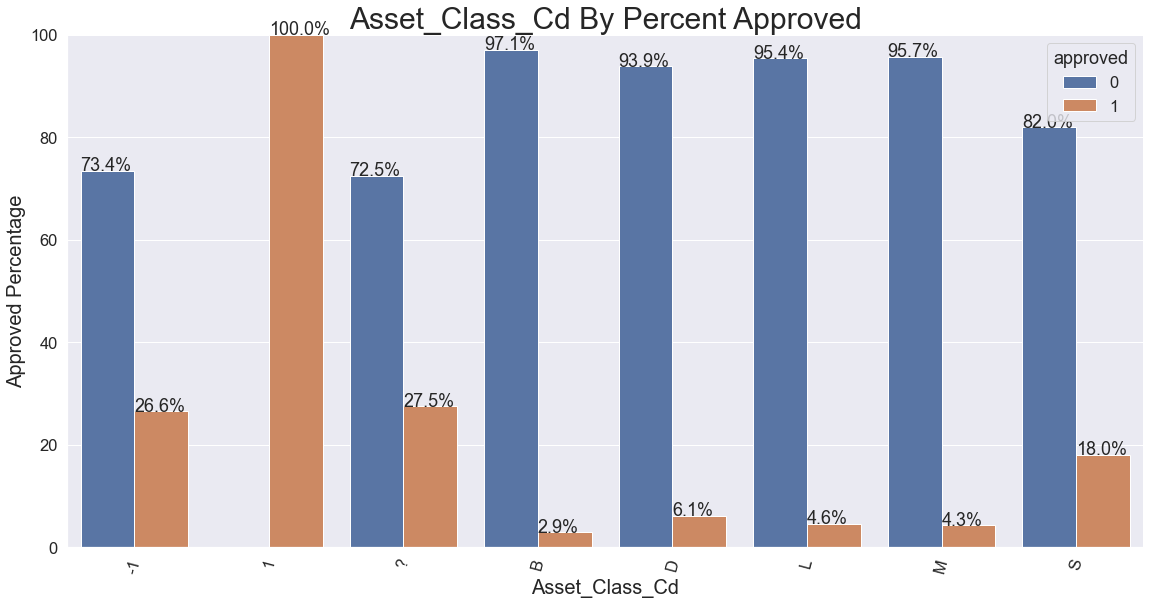

In [24]:
plotting_percentages_sbn(df, 'asset_class_cd','approved')

In [107]:
df[df['asset_class_cd']=='1']

gender date_of_birth workclass education_level  education_num  \
10781   Male    03/01/1986   Private         Masters             14   

            marital_status       occupation relationship  capital_gain  \
10781   Married-civ-spouse   Prof-specialty      Husband             0   

       capital_loss  ...  institute_type  account_type asset_class_cd  \
10781             0  ...             PVT           195              1   

       asset_code portfolio_type  Age age_group  zipcode state  edu_group  
10781         2.0              I   35     25-35    48298    NM         pg  

[1 rows x 24 columns]

In [118]:
# Checking type of asset class cd for portfolio our data point i.e. I
df[df['portfolio_type']=='I'].groupby(['asset_class_cd'])['asset_class_cd'].count()
# For portfolio type I, asset class_cd can be -1 or S

asset_class_cd
-1    7949
1        1
?       87
B      192
D       95
L      118
M       54
S     6606
Name: asset_class_cd, dtype: int64

In [117]:
# Checking asset class_cd for acc_type 195 i.e. our data point
df[df['account_type']==195].groupby(['asset_class_cd'])['asset_class_cd'].count()
# again we find -1 or S

asset_class_cd
-1    22
1      1
?      1
B      1
M      2
S     39
Name: asset_class_cd, dtype: int64

In [127]:
# As confused, we check approval rate for asset_class_cd = -1 and S
perc_with_target('asset_class_cd','approved')
#Since the asset_class cd doesn't depend much on other variabe\le, we consider target variable
# for S, approved rate is much higher so we replace by S

asset_class_cd  approved     Percent
0              -1         0   73.420362
1              -1         1   26.579638
2               1         1  100.000000
3               ?         0   72.463768
4               ?         1   27.536232
5               B         0   97.101449
6               B         1    2.898551
7               D         0   93.877551
8               D         1    6.122449
9               L         0   95.384615
10              L         1    4.615385
11              M         0   95.714286
12              M         1    4.285714
13              S         0   81.965699
14              S         1   18.034301

In [147]:
df['asset_class_cd'].value_counts()

-1    31637
S      7580
?       276
B       207
L       130
D        98
M        70
1         1
Name: asset_class_cd, dtype: int64

In [5]:
def change(value):
    if value == '1':
        value = 'S'
    return value
        
df['asset_class_cd'] = df['asset_class_cd'].apply(change)

In [151]:
df['asset_class_cd'].value_counts()

-1    31637
S      7581
?       276
B       207
L       130
D        98
M        70
Name: asset_class_cd, dtype: int64

# Inquiry_purpose_code

1. Mode is very high as compared to other frequencies
2. Institute type, approved, portfolio type, account type are the four most corelating column

In [152]:
df.isna().sum()

gender                     0
date_of_birth              0
workclass                  0
education_level            0
education_num              0
marital_status             0
occupation                 0
relationship               0
capital_gain               0
capital_loss               0
hours_per_week             0
approved                   0
address                    0
inquiry_purpose_code    1129
institute_type             0
account_type               0
asset_class_cd             0
asset_code                74
portfolio_type             5
Age                        0
age_group                  0
zipcode                    0
state                      0
edu_group                  0
dtype: int64

In [87]:
df['inquiry_purpose_code'].value_counts()

13.0    18157
99.0     7836
7.0      5206
16.0     3117
2.0      2142
14.0      976
6.0       427
1.0       306
10.0      159
8.0       153
5.0       114
3.0       107
11.0       99
4.0        37
17.0       19
18.0        7
9.0         5
12.0        3
Name: inquiry_purpose_code, dtype: int64

In [6]:
df['inquiry_purpose_code'] = df['inquiry_purpose_code'].fillna(df['inquiry_purpose_code'].mode()[0])

In [154]:
df['inquiry_purpose_code'].value_counts()

13.0    19286
99.0     7836
7.0      5206
16.0     3117
2.0      2142
14.0      976
6.0       427
1.0       306
10.0      159
8.0       153
5.0       114
3.0       107
11.0       99
4.0        37
17.0       19
18.0        7
9.0         5
12.0        3
Name: inquiry_purpose_code, dtype: int64

In [155]:
perc_without_target('inquiry_purpose_code')

index    Percent
0    13.0  48.216205
1    99.0  19.590490
2     7.0  13.015325
3    16.0   7.792695
4     2.0   5.355134
5    14.0   2.440061
6     6.0   1.067527
7     1.0   0.765019
8    10.0   0.397510
9     8.0   0.382510
10    5.0   0.285007
11    3.0   0.267507
12   11.0   0.247506
13    4.0   0.092502
14   17.0   0.047501
15   18.0   0.017500
16    9.0   0.012500
17   12.0   0.007500

posx and posy should be finite values
posx and posy should be finite values


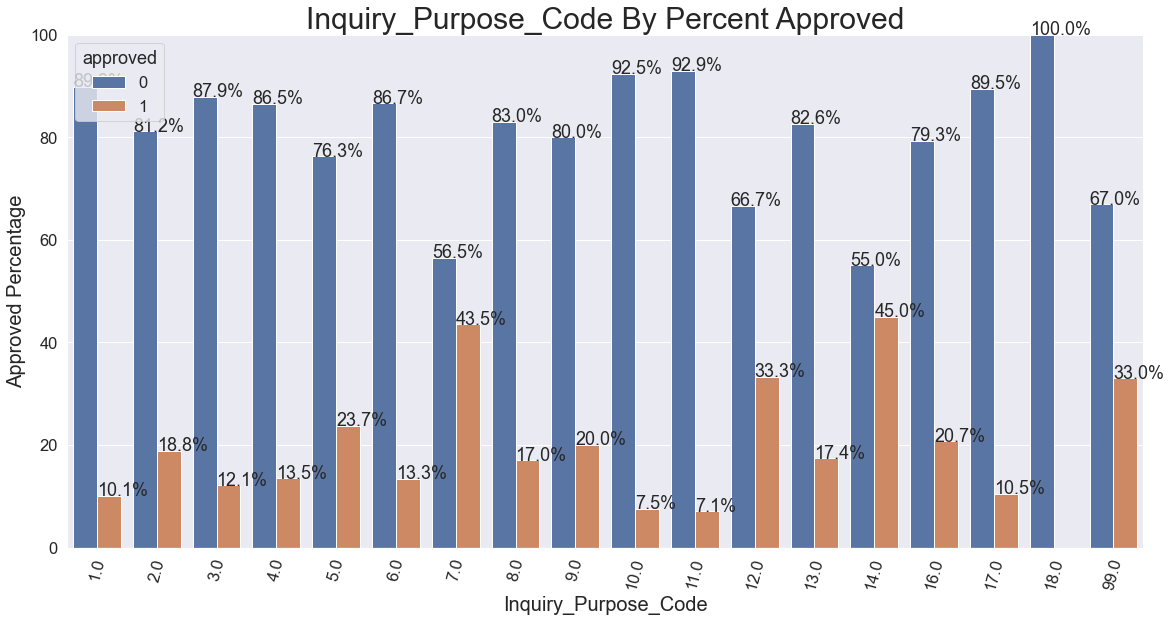

In [161]:
plotting_percentages_sbn(df,'inquiry_purpose_code','approved')

# asset_code
1. Mode is repeated very large no of times as compared to others so is suitable to replace

In [88]:
df['asset_code'].isna().sum()

74

In [156]:
perc_without_target('asset_code')

index    Percent
0    1.0  96.819036
1    2.0   2.602379
2    4.0   0.440827
3   19.0   0.137758

In [7]:
df['asset_code'] = df['asset_code'].fillna(df['asset_code'].mode()[0])

In [158]:
perc_without_target('asset_code')

index    Percent
0    1.0  96.824921
1    2.0   2.597565
2    4.0   0.440011
3   19.0   0.137503

# portfolio_type

1. Difference between mode and 2nd most repeated value is considerable so currently replacing with mode.
2. But, approval rate is also different so will try with model

In [159]:
df['portfolio_type'].isna().sum()

5

In [160]:
perc_without_target('portfolio_type')

index    Percent
0     R  59.683953
1     I  37.760664
2     M   2.532880
3     F   0.022503

In [162]:
perc_with_target('portfolio_type','approved')

portfolio_type  approved     Percent
0              F         0  100.000000
1              I         0   79.949676
2              I         1   20.050324
3              M         0   62.685094
4              M         1   37.314906
5              R         0   72.907415
6              R         1   27.092585

In [8]:
df['portfolio_type'] = df['portfolio_type'].fillna(df['portfolio_type'].mode()[0])

# Transforming variable

## Capital gain and loss groups:
1. Cap_gain group
2. Cap_loss_grp
3. Net cap_gain
4. net_cap_grp_log
5. cap_gain_pow3

In [14]:

fig = px.scatter(x=df.index,y=(df['capital_gain']**2),color =df['approved'])
fig.show()

df['cap_gain_grp'] = pd.cut(df['capital_gain'], bins = [0,3100,6850,100000], labels = ['low','mid','high'])

In [15]:
df['cap_gain_pow3'] = pd.cut((df['capital_gain']**3), bins = [0,46908800,10000000000], labels = ['low','high'])

In [16]:
# Capital loss transformation

fig = px.scatter(x=df.index,y=(np.log(df['net_cap_gain']))**3,color =df['approved'])
fig.show()
df['net_cap_grp_log'] = pd.cut(np.log(df['net_cap_gain'])**3, bins = [0,576,689,1300], labels = ['low_net_gain','mid_net_gain','high_net_gain'])

In [122]:
# Net capital gain
df['net_cap_gain'] = df['capital_gain']-df['capital_loss']

In [ ]:
df['cap_gain_grp'] = pd.cut(df['capital_gain'], bins = [0,3100,6850,100000], labels = ['low','mid','high'])

df['cap_loss_grp'] = pd.cut(df['capital_loss'], bins = [0,1800,27000,100000], labels = ['low_loss','mid_los

# hours group

In [17]:
# hours group transformation
df['hours_group'] = pd.cut(df.hours_per_week,bins=[0,35,40,45,60,99], labels=['0-35','35-40','40-45','45-60','60-99'])

plotting_percentages_plotly(df,'hours_group','approved')

## Age group

In [18]:
# Age transformation no effect 
df['age_group'] = pd.cut(df.Age, bins=[0,25,35,40,45,50,55,65,99], labels =['0-25','25-35','35-40', '40-45','45-50','50-55','55-65','65-99'])
pd.crosstab(df['age_group'],df['approved'])
plotting_percentages_plotly(df,'age_group','approved')

In [25]:
# Trying log of ages and hours: not useful
df['log_age'] = np.log(df['Age'])
df['log_hours'] = np.log(df['hours_per_week'])

# Creating seperate column for relationship as husband

In [19]:
# relatinship
#plotting_percentages_plotly(df,'relationship','approved')

#df['relationship'].unique()
#df['rel_grp'] = np.where(((df['relationship'] == ' Husband')|(df['relationship'] == ' Wife')), 1,0)
#df['rel_grp'] = np.where(((df['relationship'] == ' Not-in-family')|(df['relationship'] == ' Unmarried')), 2,df['rel_grp'])

plotting_percentages_plotly(df,'relationship','approved')

In [88]:
def top_rel(t):
    if t == ' Husband' or t== ' Wife':
        return 1
    else:
        return 0
    
df['husb_or_wife'] = df['relationship'].apply(grouping_relationship)

# Seperate grp for marital_status widowed

In [21]:
def top_mar_st(group):
    if group == ' Widowed':
        return -1
    else:
        return 0

df_train['never_married'] = df_train['marital_status'].apply(top_mar_st)
df_test['never_married'] = df_test['marital_status'].apply(top_mar_st)

# Grouping inquiry purpose code and creating a column for 7

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


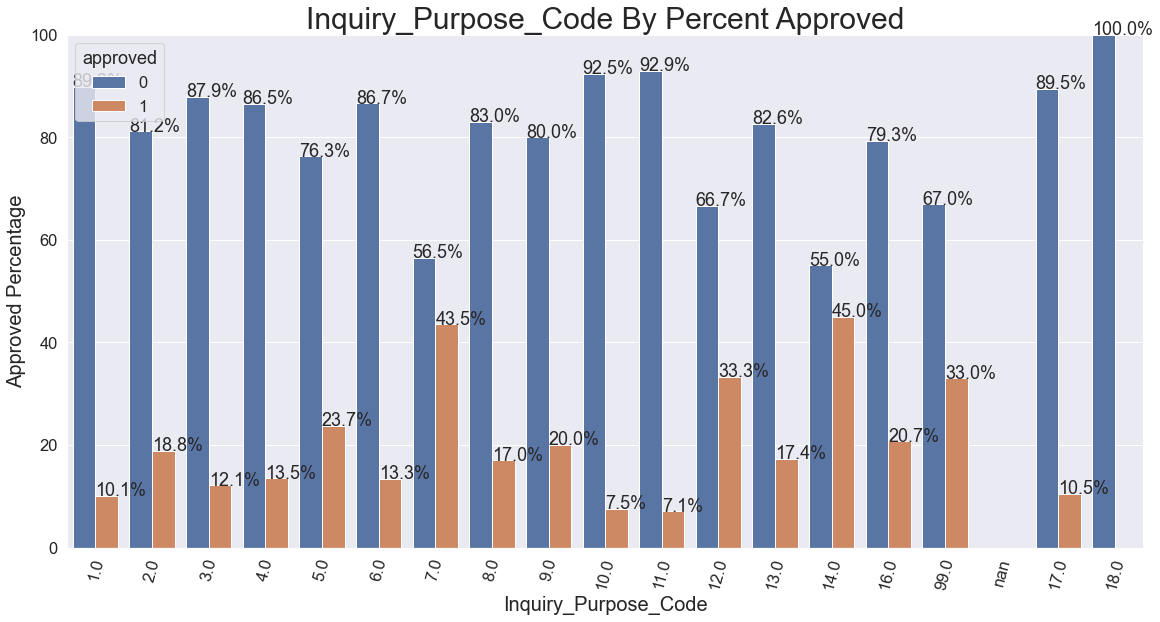

In [90]:
# Inquiry purpose code data
#df['inquiry_purpose_code'] = df.inquiry_purpose_code.astype('int')
plotting_percentages_sbn(df,'inquiry_purpose_code','approved')

In [94]:
def grping(t):
    if t not in [2,7,13,16,99]:
        return 1
    else:
        return t
 
df['inquiry_grp'] = df['inquiry_purpose_code']
df['inquiry_grp'] = df.inquiry_purpose_code.apply(grping)

In [97]:
def grping(t):
    if t == 7:
        return 1
    else:
        return 0
 
df['inquiry_is_seven'] = df.inquiry_purpose_code.apply(grping)

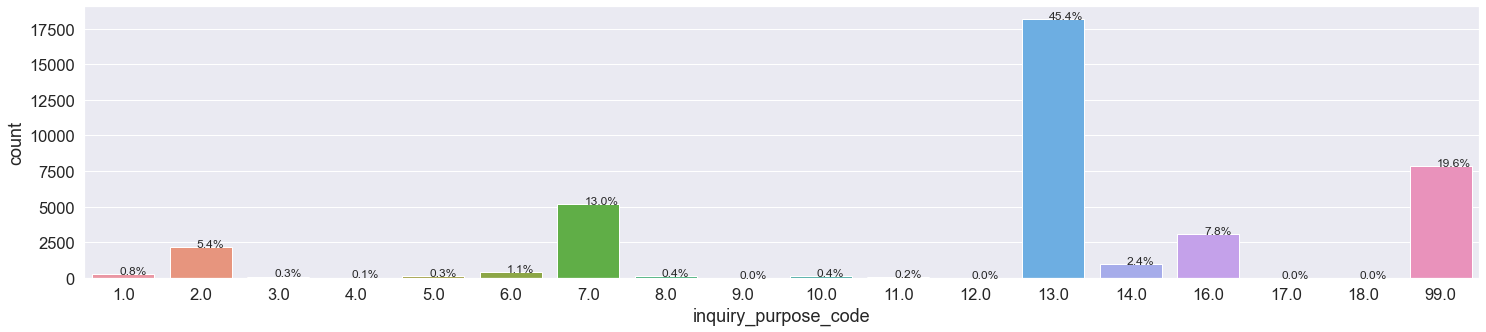

In [93]:
plt.figure(figsize=(25,5))
ax = sns.countplot(data=df,x='inquiry_purpose_code')
without_hue(ax, df['inquiry_purpose_code'])

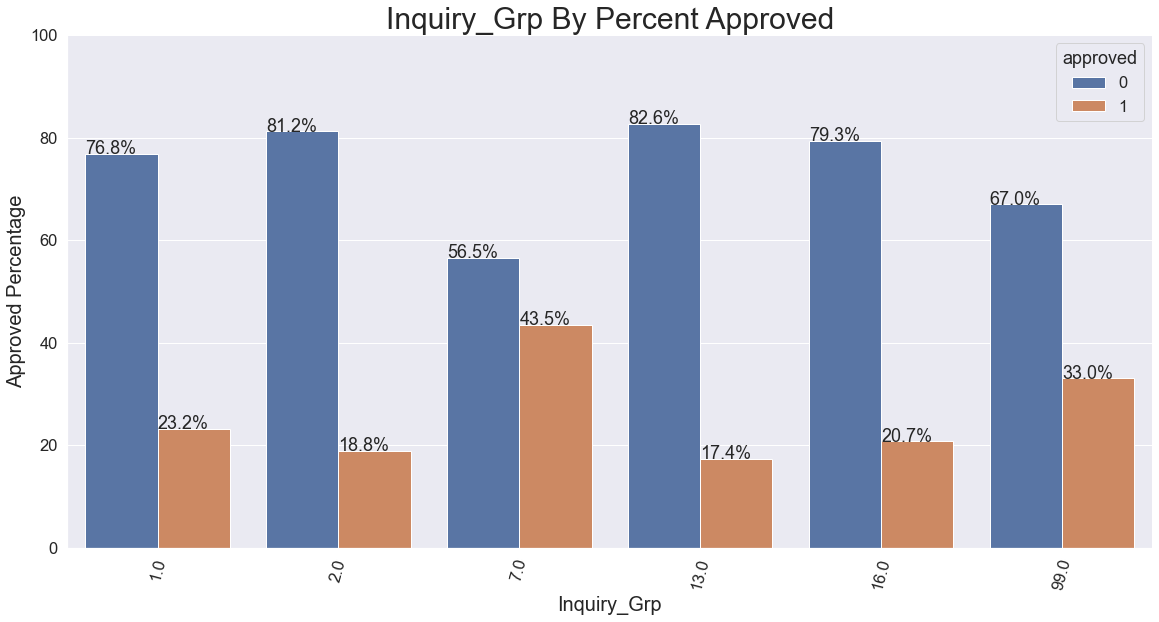

In [96]:
plotting_percentages_sbn(df,'inquiry_grp','approved')

# Occupation
Creating group considering the approval rate and frequency

In [25]:
(cramers_v(df_train['approved'],df_train['occupation']))

0.3425181393113148

In [22]:
plotting_percentages_plotly(df,'occupation','approved')

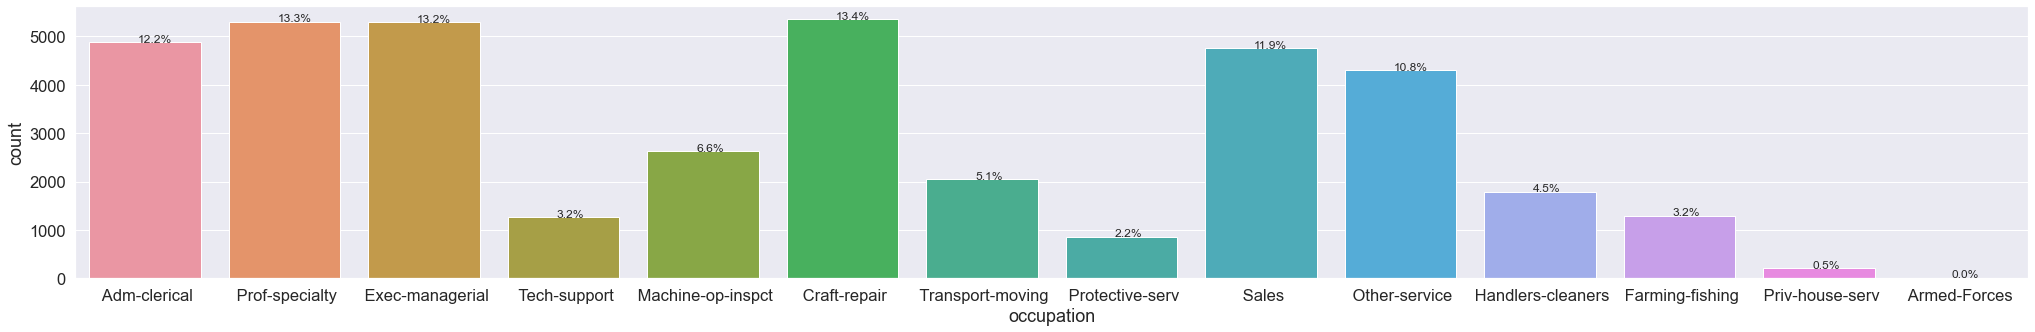

In [110]:
plt.figure(figsize=(35,5))
ax = sns.countplot(data=df,x='occupation')
without_hue(ax, df['occupation'])

In [120]:
def grping(t):
    if t == ' Exec-managerial' or t == ' Prof-specialty':
        return 'a'
    elif t == ' Sales' or t== ' Transport-moving' or t== ' Tech-support' or t== ' Protective-serv' or t== ' Craft-repair' or t== ' Armed-Forces':
        return 'b'
#    elif t== ' Adm-clerical' or t == ' Farming-fishing' or t== ' Machine-op-inspct' or t== ' Handlers-cleaners' or t== ' Other-service':
    else:
        return 'c'
    
 
df['occupation_grp'] = df.occupation.apply(grping)

In [23]:
def top_occ(group):
    if group == 'c':
        return 1
    else:
        return 0

df_train['Top_occupation'] = df_train['occupation_grp'].apply(top_occ)
df_test['Top_occupation'] = df_test['occupation_grp'].apply(top_occ)

In [121]:
df['occupation_grp'].value_counts()

c    15101
b    14298
a    10600
Name: occupation_grp, dtype: int64

# Adding different salaries

In [24]:
def inc_occ(occupation, gender):
    if occupation ==' Armed-Forces':
        if gender == ' Male':
            return 51844
        else:
            return 41903
    elif occupation ==' Protective-serv':
        if gender == ' Male':
            return 55317
        else:
            return 34206
    elif occupation ==' Priv-house-serv': 
        if gender == ' Male':
            return 26822
        else:
            return 16811
    elif occupation ==' Other-service':
        if gender == ' Male':
            return 22219
        else:
            return 20788
    elif occupation ==' Farming-fishing':
        if gender == ' Male':
            return 26822
        else:
            return 16811
    elif occupation ==' Prof-specialty':
        if gender == ' Male':
            return 72039
        else:
            return 50711
    elif occupation ==' Machine-op-inspct':
        if gender == ' Male':
            return 39372
        else:
            return 34335
    elif occupation ==' Sales':
        if gender == ' Male':
            return 48908
        else:
            return 24920
    elif occupation ==' Transport-moving':
        if gender == ' Male':
            return 33292
        else:
            return 23157
    elif occupation ==' Exec-managerial':
        if gender == ' Male':
            return 80366
        else:
            return 60576
    elif occupation ==' Handlers-cleaners':
        if gender == ' Male':
            return 28163
        else:
            return 18701
    elif occupation ==' Craft-repair':
        if gender == ' Male':
            return 42807
        else:
            return 27609
    elif occupation ==' Adm-clerical':
        if gender == ' Male':
            return 39372
        else:
            return 34335
    elif occupation ==' Tech-support':
        if gender == ' Male':
            return 48908
        else:
            return 24920
        
df_train['income_occ'] = df_train.apply(lambda x: inc_occ(x.occupation, x.gender), axis=1)
df_test['income_occ'] = df_test.apply(lambda x: inc_occ(x.occupation, x.gender), axis=1)

In [25]:
def inc_age(agrp,gender):
    if agrp == '0-25':
        if gender == ' Male':
            return 20757
        else:
            return 18964
    elif agrp == '25-35':
        if gender == ' Male':
            return 54139
        else:
            return 42510

    elif agrp == '35-45':
        if gender == ' Male':
            return 79132
        else:
            return 53500
    elif agrp == '45-55':
        if gender == ' Male':
            return 86724
        else:
            return 57151
    elif agrp == '55-65':
        if gender == ' Male':
            return 81676
        else:
            return 49168
    else:
        if gender == ' Male':
            return 58576
        else:
            return 35316
        
df_train['income_age'] = df_train.apply(lambda x: inc_age(x.age_group, x.gender), axis=1)
df_test['income_age'] = df_test.apply(lambda x: inc_age(x.age_group, x.gender), axis=1)

In [26]:
df_train['income_occ_age'] = (df_train['income_occ']+df_train['income_age'])/2
df_test['income_occ_age'] = (df_test['income_occ']+df_test['income_age'])/2

In [27]:
def inc_rel(relation, gender):
    if relation ==' Husband' or relation ==' Wife' :
        if gender == ' Male':
            return 55727
        else:
            return 33198
    if relation ==' Other-relative':
        if gender == ' Male':
            return 25416
        else:
            return 20601
    if relation ==' Own-child':
        if gender == ' Male':
            return 16471
        else:
            return 14152
    if relation ==' Unmarried'or relation == ' Not-in-family':
        if gender == ' Male':
            return 52271
        else:
            return 31968


df_train['income_rel'] = df_train.apply(lambda x: inc_rel(x.relationship, x.gender), axis=1)        
df_test['income_rel'] = df_test.apply(lambda x: inc_rel(x.relationship, x.gender), axis=1)

In [28]:
def inc_ms(status, gender):
    

    if status ==' Married-civ-spouse' or status ==' Married-AF-spouse' :
        if gender == ' Male':
            return 57404
        else:
            return 32743
    if status ==' Widowed' or status == ' Separated':
        if gender == ' Male':
            return 42286
        else:
            return 34502
    if status ==' Married-spouse-absent':
        if gender == ' Male':
            return 37764
        else:
            return 26408
    if status ==' Divorced':
        if gender == ' Male':
            return 42286
        else:
            return 34502
    if status ==' Never-married':
        if gender == ' Male':
            return 28581
        else:
            return 26420


df_train['income_mar_st'] = df_train.apply(lambda x: inc_ms(x.marital_status, x.gender), axis=1)        
df_test['income_mar_st'] = df_test.apply(lambda x: inc_ms(x.marital_status, x.gender), axis=1)

In [29]:
def inc_ed(education, gender):
    
        
    if education =='  Doctorate' :
        if gender == ' Male':
            return 106472
        else:
            return 86047
    elif education ==' Prof-school' :
        if gender == ' Male':
            return 127625
        else:
            return 82093
    elif education ==' Masters' :
        if gender == ' Male':
            return 88280
        else:
            return 66601
    elif education ==' Bachelors' :
        if gender == ' Male':
            return 69505
        else:
            return 45942
    
    elif education ==' Assoc-voc' or education == ' Assoc-acdm':
        if gender == ' Male':
            return 51250
        else:
            return 31652
    elif education ==' Some-college' :
        if gender == ' Male':
            return 45639
        else:
            return 28653
    elif education ==' HS-grad' :
        if gender == ' Male':
            return 37144
        else:
            return 22052
    else :
        if gender == ' Male':
            return 24420
        else:
            return 13129
    


df_train['income_ed'] = df_train.apply(lambda x: inc_ed(x.education_level, x.gender), axis=1)        
df_test['income_ed'] = df_test.apply(lambda x: inc_ed(x.education_level, x.gender), axis=1)

In [30]:
def inc_work(workclass, occupation, gender):

        
    if workclass ==' Private' :
        if gender == ' Male':
            if occupation == ' Farming-fishing':
                return 30231
            else:
                return 46956
        else:
            if occupation == ' Farming-fishing':
                return 21440
            else:
                return 34321
    if workclass ==' Self-emp-inc' or workclass ==' Self-emp-not-inc' :
        if gender == ' Male':
            if occupation == ' Farming-fishing':
                return 36081
            else:
                return 50380
        else:
            if occupation == ' Farming-fishing':
                return 25083
            else:
                return 30393
    if workclass ==' Local-gov' or workclass == ' State-gov' :
        if gender == ' Male':
            return 55030
        else:
            return 42460
    if workclass ==' Federal-gov' :
        if gender == ' Male':
            return 66964
        else:
            return 60727
    else:
        return 0



df_train['income_workclass'] = df_train.apply(lambda x: inc_work(x.workclass, x.occupation, x.gender), axis=1)        
df_test['income_workclass'] = df_test.apply(lambda x: inc_work(x.workclass, x.occupation, x.gender), axis=1)

In [31]:
df_test['net_income_occ_age_edu'] = (df_test['income_occ_age']+ df_test['income_ed'])/2
df_train['net_income_occ_age_edu'] = (df_train['income_occ_age']+ df_train['income_ed'])/2
df_train.corrwith(df_train['approved'])

education_num             0.332859
capital_gain              0.220710
capital_loss              0.145728
hours_per_week            0.226637
approved                  1.000000
Age                       0.236432
log_age                   0.268691
log_hours                 0.203285
net_cap_gain              0.212217
husb_or_wife              0.449913
inquiry_is_seven          0.169186
never_married             0.061248
Top_occupation           -0.271114
income_occ                0.394026
income_age                0.367396
income_occ_age            0.461290
income_rel                0.342679
income_mar_st             0.404690
income_ed                 0.379445
income_workclass          0.232979
net_income_occ_age_edu    0.477141
dtype: float64

# Determining correlations


In [15]:
# CREATING A TARGET ENCODED DATAFRAME
targ_col2 = df_train.loc[:, df_train.columns != 'approved'].columns

df_train_encoded, encoder = target_encoding(df_train[targ_col2])

In [22]:
cat_column= df_train.columns.drop(['log_age','log_hours','net_cap_gain','approved','date_of_birth','address','Age','capital_gain','capital_loss','hours_per_week'])

In [23]:
#determining correlations of categorical with target
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

corr_list = []
for i in cat_column:
    print(i,(cramers_v(df_train['approved'],df_train[i])))

gender 0.21463963547394596
workclass 0.16395019665712118
education_level 0.3651788930364938
education_num 0.3651788930364938
marital_status 0.4486348967809671
occupation 0.3425181393113148
relationship 0.4545544400173401
inquiry_purpose_code 0.2354592510958683
institute_type 0.11118873567912435
account_type 0.11997461749363332
asset_class_cd 0.09582310886514252
asset_code 0.01815456290925787
portfolio_type 0.09444669418748056
age_group 0.3049089158738373
zipcode 0.0
state 0.0
city 0.0536384408731424
email_domain 0.03475018183820797
edu_group 0.3640163889584718
hours_group 0.268966414511895
cap_gain_grp 0.3685306985929128
cap_loss_grp 0.19042366044420955
cap_gain_pow3 0.2639802376750334
husb_or_wife 0.4498120505815493
inquiry_is_seven 0.16898900750579787
occupation_grp 0.3343315989864675


In [24]:
# Determining pearson correlation for categorical columns with target encoding
df_train_encoded[cat_column].corrwith(df_train['approved'],method='pearson').sort_values(ascending = False)

relationship            0.454719
husb_or_wife            0.449913
marital_status          0.448826
city                    0.388771
cap_gain_grp            0.368610
education_level         0.365713
edu_group               0.364297
zipcode                 0.356000
occupation              0.343063
occupation_grp          0.334420
education_num           0.332859
age_group               0.305211
hours_group             0.269543
cap_gain_pow3           0.264167
inquiry_purpose_code    0.236340
gender                  0.214787
cap_loss_grp            0.190714
email_domain            0.183035
inquiry_is_seven        0.169186
workclass               0.164498
account_type            0.123189
institute_type          0.112255
asset_class_cd          0.096246
portfolio_type          0.094842
state                   0.037169
asset_code              0.020458
dtype: float64

In [19]:
# Performing t test for numerical columns
from sklearn.feature_selection import f_classif

num_col = ['capital_gain','capital_loss','net_cap_gain','Age','log_age','log_hours','hours_per_week']

f_value = f_classif(df_train[num_col],df_train['approved'])

for i in range(len(num_col)):
    print(num_col[i],f_value[0][i])

capital_gain 1638.483136320227
capital_loss 694.2551803427951
net_cap_gain 1508.976606836648
Age 1894.5422257872294
log_age 2489.772359819026
log_hours 1379.2715766618958
hours_per_week 1732.4964964907956


In [20]:
# Determining pearson correlation for num vs target to check if it performs same as t test

num_col = ['capital_gain','capital_loss','net_cap_gain','Age','log_age','log_hours','hours_per_week','cap_gain_pow3']
df_train[num_col].corrwith(df_train['approved'],method='pearson').sort_values(ascending = False)

log_age           0.268691
Age               0.236432
hours_per_week    0.226637
capital_gain      0.220710
net_cap_gain      0.212217
log_hours         0.203285
capital_loss      0.145728
dtype: float64

In [21]:
# Determining spearman correlation
df_train[num_col].corrwith(df_train['approved'],method='spearman')#.sort_values(ascending = False)

capital_gain      0.275357
capital_loss      0.136356
net_cap_gain      0.138763
Age               0.272184
log_age           0.272184
log_hours         0.263627
hours_per_week    0.263627
dtype: float64

# Base line model
* columns used: gender, workclass, education_level, education_num, marital_status, occupation, relationship, capital_gain, capital_loss, hours_per_week, approved, inquiry_purpose_code, institute_type, account_type, asset_class_cd, asset_code, portfolio_type
       
* All features target encoded

<b> 
    auc_roc_test: 80
 <br>   precision: 77
  <br>  recall: 67

In [36]:
df1 = pd.read_csv('ABC_payments_bank_credcard_train.csv')
df1=df1.drop(['user_id','email','date_of_birth','address'], axis=1)
df1.columns

Index(['gender', 'workclass', 'education_level', 'education_num',
       'marital_status', 'occupation', 'relationship', 'capital_gain',
       'capital_loss', 'hours_per_week', 'approved', 'inquiry_purpose_code',
       'institute_type', 'account_type', 'asset_class_cd', 'asset_code',
       'portfolio_type'],
      dtype='object')

[11:54:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:54:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

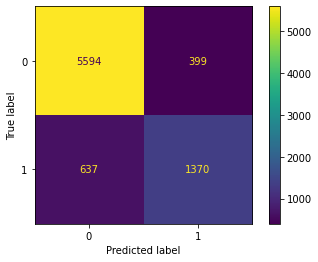

roc_auc_score for test is 0.8080165940150571 
 precision for test is 0.7744488411531939 
 recall for test is 0.6826108619830593 
 f1_score is 0.7256355932203389

 
 FOR LIGHT GBM
roc_auc_score for training is 0.8025224296537259
precision for training is 0.7841931613677264 
 Recall for training is 0.6646752256260328 
 f1_score is 0.7195046439628482
roc_auc_score for test is 0.806195086760829 
 precision for test is 0.7791164658634538 
 recall for test is 0.6766317887394121 
 f1_score is 0.7242666666666667


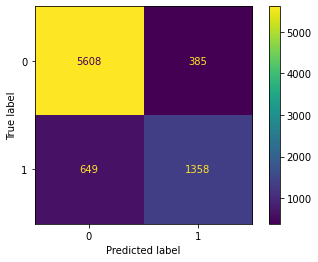

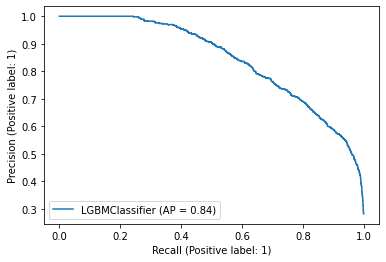

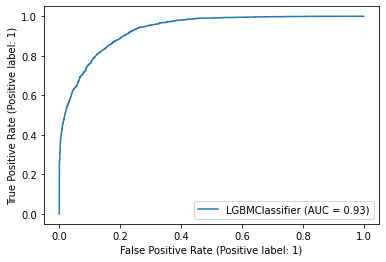

In [37]:
# TARGET ENCODING ON PARENT
targ_col1 = df1.loc[:, df1.columns != 'approved'].columns

x, encoder = target_encoding(df_train1[targ_col1])

y = df_train1['approved']


x_test_main = encoder.transform(df_test1[targ_col1])

y_test_main = df_test1['approved']

models(x,y, x_test_main, y_test_main)

[00:41:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:41:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:41:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

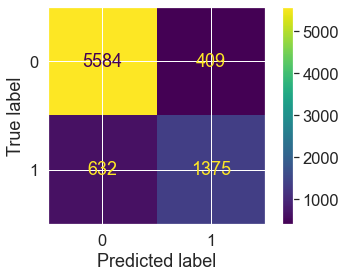

roc_auc_score for test is 0.8084279275830106 
 precision for test is 0.7707399103139013 
 recall for test is 0.6851021425012457 
 f1_score is 0.7254022685307306

 
 FOR LIGHT GBM
roc_auc_score for training is 0.8020083826273827
precision for training is 0.785219747140277 
 Recall for training is 0.6631498665310792 
 f1_score is 0.7190407277237958
roc_auc_score for test is 0.8025357768750472 
 precision for test is 0.7716084716657127 
 recall for test is 0.6716492277030394 
 f1_score is 0.7181672882258924


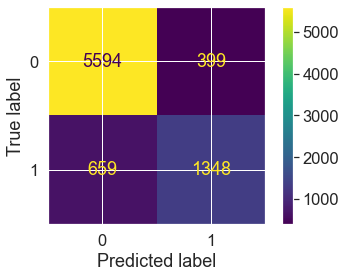

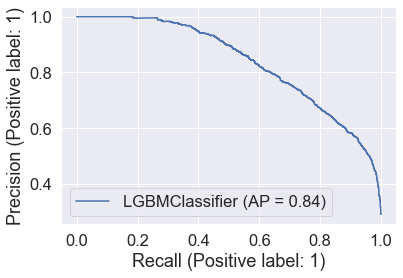

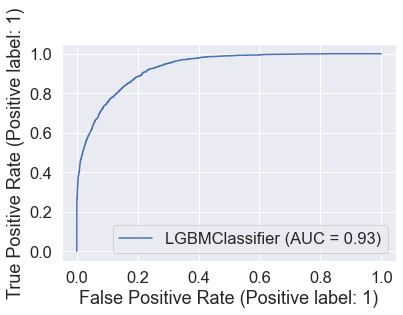

In [133]:
# Everything is label encoded
targ_col1 = df1.loc[:, df1.columns != 'approved'].columns

x, encoder = label_encoding(df_train[targ_col1])

y = df_train['approved']


x_test_main = encoder.transform(df_test[targ_col1])

y_test_main = df_test['approved']

models(x,y, x_test_main, y_test_main)

[00:45:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:45:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:45:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

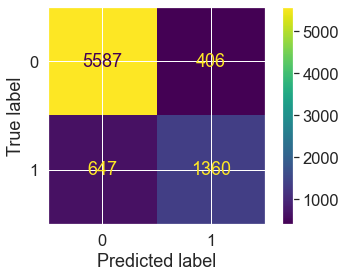

roc_auc_score for test is 0.804941298813073 
 precision for test is 0.7701019252548131 
 recall for test is 0.6776283009466866 
 f1_score is 0.7209117413199045

 
 FOR LIGHT GBM
roc_auc_score for training is 0.8019131767356148
precision for training is 0.782706428892552 
 Recall for training is 0.663912546078556 
 f1_score is 0.7184319119669876
roc_auc_score for test is 0.8065229896596685 
 precision for test is 0.7748720864127345 
 recall for test is 0.6791230692575984 
 f1_score is 0.7238449283058948


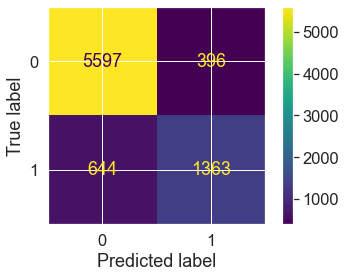

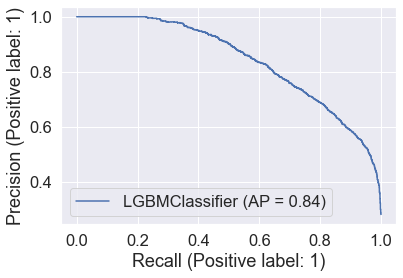

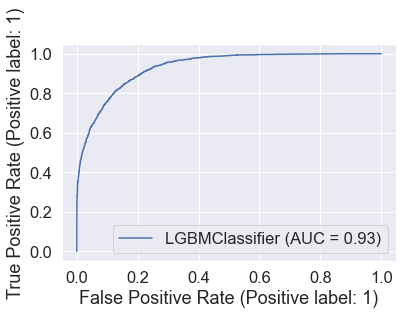

In [136]:
# After converting ints to object
targ_col1 = df1.loc[:, df1.columns != 'approved'].columns

x, encoder = target_encoding(df_train[targ_col1])

y = df_train['approved']


x_test_main = encoder.transform(df_test[targ_col1])

y_test_main = df_test['approved']

models(x,y, x_test_main, y_test_main)

# Model1: Only top 5 columns using target


1. Auc-roc: 75
2. precision: 69 
3. recall: 58



 
 FOR LIGHT GBM
roc_auc_score for training is 0.750257321122117
precision for training is 0.693874471937236 
 Recall for training is 0.5845938731409686 
 f1_score is 0.6345636426353916
roc_auc_score for test is 0.7481734835800379 
 precision for test is 0.6875365710942072 
 recall for test is 0.5854509217737918 
 f1_score is 0.632400430570506


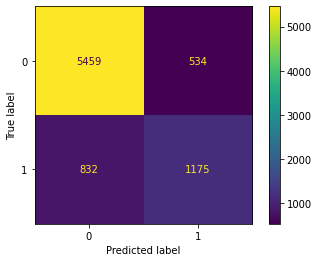

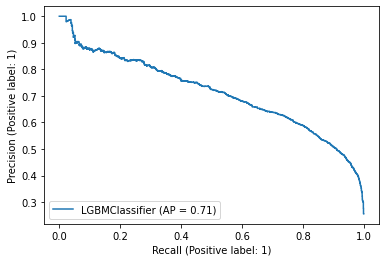

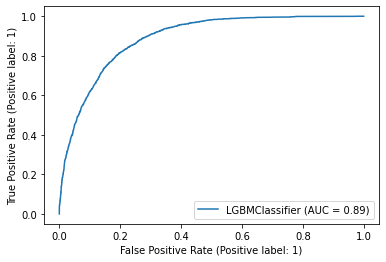

In [33]:
targ_col1 = ['relationship','edu_group','occupation','Age','hours_per_week']

x, encoder = target_encoding(df_train[targ_col1])

y = df_train['approved']


x_test_main = encoder.transform(df_test[targ_col1])

y_test_main = df_test['approved']

models(x,y, x_test_main, y_test_main)

# Model 2

### Considering only correlated
1. Standard scaling and normalisation for conitnuos.
2. One hot for categorical with less features
3. Target for others; Moving one hot to target

* <b> one hot gender:</b> Gender, marital status, relationship
*  <b> target:</b> edu group, inquiry purpose code, Institute type, acc_type, asset_class_cd, workclass, , asset_code, portfolio_type
* <b> standardisation </b>: hours, Age
* <b> Normalisation </b> : capital_gain, capital_loss

1. Auc-roc: 72 
2. precision: 69 
3. recall: 52


 
 FOR LIGHT GBM
roc_auc_score for training is 0.7779109310048493
precision for training is 0.7195805200402241 
 Recall for training is 0.6367103088852167 
 f1_score is 0.6756137038036149
roc_auc_score for test is 0.7222086704543442 
 precision for test is 0.6933774834437086 
 recall for test is 0.5216741405082213 
 f1_score is 0.5953938015353994


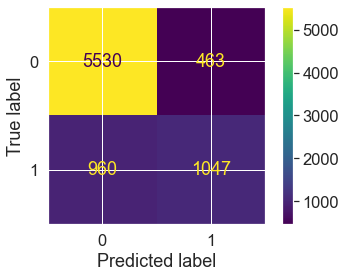

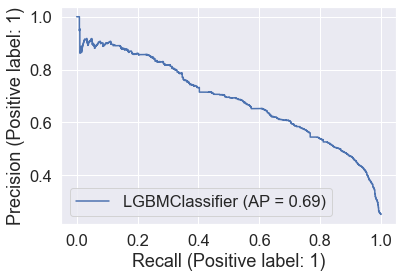

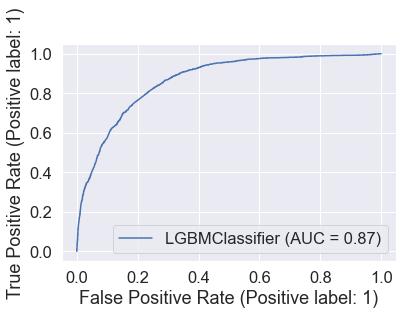

In [341]:
onehotcol1 = []

targ_col1 = ['gender', 'marital_status', 'relationship', 'edu_group','inquiry_purpose_code','institute_type', 'account_type', 'asset_class_cd', 'workclass', 'asset_code', 'portfolio_type']

x, encoder = target_encoding(df_train[targ_col1])
x_test_main = encoder.transform(df_test[targ_col1])


x['hours'] = sc.fit_transform(df_train['hours_per_week'].values.reshape((-1,1)))
x_test_main['hours'] = pd.DataFrame(sc.transform(df_test['hours_per_week'].values.reshape((-1,1))))

x['Age'] = sc.fit_transform(df_train['Age'].to_numpy().reshape((-1,1)))
x_test_main['Age'] = pd.DataFrame(sc.transform(df_test['Age'].to_numpy().reshape((-1,1))))

x['capital_gain'] = nc.fit_transform(df_train['capital_gain'].values.reshape((-1,1)))
x_test_main['capital_gain'] = pd.DataFrame(nc.transform(df_test['capital_gain'].values.reshape((-1,1))))

x['capital_loss'] = nc.fit_transform(df_train['capital_loss'].values.reshape((-1,1)))
x_test_main['capital_loss'] = pd.DataFrame(nc.transform(df_test['capital_loss'].values.reshape((-1,1))))

y = df_train['approved']
y_test_main = df_test['approved']

models(x,y,x_test_main,y_test_main)




# Model 3

### Created capital gain group 

* <b> one hot gender:</b> cap_gain_group
*  <b> target:</b> gender, marital status, relationship, Institute type, acc_type, asset_class_cd, workclass, edu group, inquiry purpose code, asset_code, portfolio_type
* <b> standardisation </b>: hours, Age
* <b> Normalisation </b> :  capital_loss

1. Auc-roc: 71
2. precision: 68 
3. recall: 50


 
 FOR LIGHT GBM
roc_auc_score for training is 0.7607858617567784
precision for training is 0.6974605954465849 
 Recall for training is 0.6074742595652727 
 f1_score is 0.6493647666281677
roc_auc_score for test is 0.7119028419720034 
 precision for test is 0.6762349799732977 
 recall for test is 0.5047334329845541 
 f1_score is 0.5780313837375177


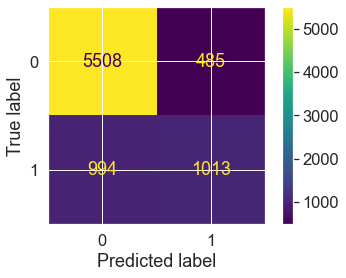

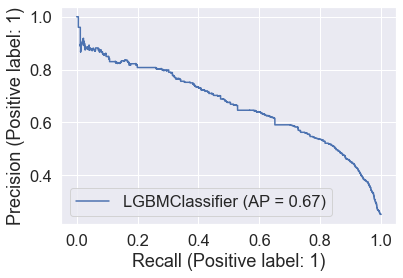

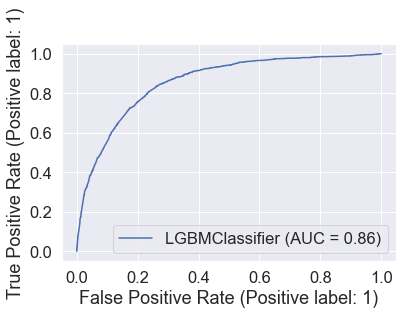

In [344]:
onehotcol1 = ['cap_gain_grp']
targ_col1 = ['gender','marital_status', 'relationship', 'education_level','institute_type', 'account_type', 'asset_class_cd', 'workclass', 'asset_code', 'portfolio_type']

x, encoder = target_encoding(df_train[targ_col1])
x_test_main = encoder.transform(df_test[targ_col1])


x['hours'] = sc.fit_transform(df_train['hours_per_week'].values.reshape((-1,1)))
x_test_main['hours'] = pd.DataFrame(sc.transform(df_test['hours_per_week'].values.reshape((-1,1))))

x['Age'] = sc.fit_transform(df_train['Age'].to_numpy().reshape((-1,1)))
x_test_main['Age'] = pd.DataFrame(sc.transform(df_test['Age'].to_numpy().reshape((-1,1))))


x['capital_loss'] = nc.fit_transform(df_train['capital_loss'].values.reshape((-1,1)))
x_test_main['capital_loss'] = pd.DataFrame(nc.transform(df_test['capital_loss'].values.reshape((-1,1))))

y = df_train['approved']
y_test_main = df_test['approved']

models(x,y,x_test_main,y_test_main)


# Model 4

### Considered cap_gain grp, cap_loss grp,, hours_grp

*  <b> target:</b> cap_gain_group, cap_loss_group, hours_group, gender, marital status, relationship, Institute type, acc_type, asset_class_cd, workclass, edu group, inquiry purpose code, asset_code, portfolio_type
* <b> standardisation </b>: Age

1. Auc-roc: 78
2. precision: 71 
3. recall: 64


 
 FOR LIGHT GBM
roc_auc_score for training is 0.7919817107556674
precision for training is 0.75303762260284 
 Recall for training is 0.6538705987034448 
 f1_score is 0.6999591781194721
roc_auc_score for test is 0.7770017104326415 
 precision for test is 0.7182940516273849 
 recall for test is 0.637767812655705 
 f1_score is 0.6756400105568752


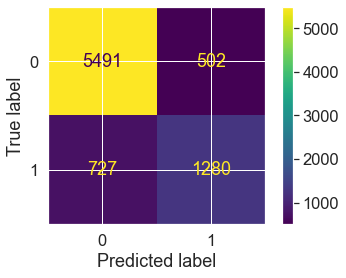

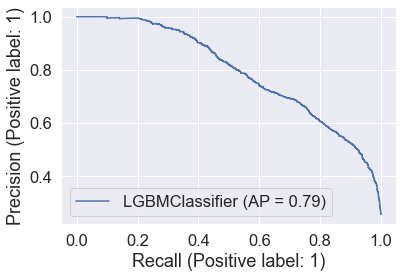

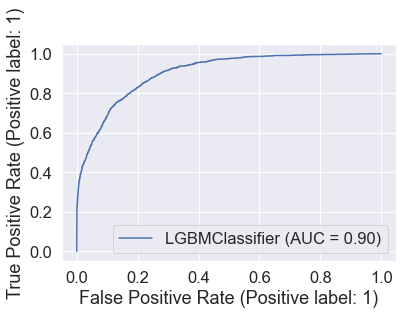

In [345]:

onehotcol1 = []
targ_col1 = ['cap_gain_grp', 'cap_loss_grp','hours_group','gender','inquiry_purpose_code', 'marital_status', 'relationship', 'education_level','institute_type', 'account_type', 'asset_class_cd', 'workclass', 'asset_code', 'portfolio_type']

x, encoder = target_encoding(df_train[targ_col1])
x_test_main = encoder.transform(df_test[targ_col1])


x['Age'] = sc.fit_transform(df_train['Age'].to_numpy().reshape((-1,1)))
x_test_main['Age'] = pd.DataFrame(sc.transform(df_test['Age'].to_numpy().reshape((-1,1))))


y = df_train['approved']
y_test_main = df_test['approved']

models(x,y,x_test_main,y_test_main)


# Model 5

### Checking zipcode, city, email domain

*  <b> target:</b> cap_gain_group, cap_loss_group, hours_group, gender, marital status, relationship, Institute type, acc_type, asset_class_cd, workclass, edu group, inquiry purpose code, asset_code, portfolio_type
* <b> standardisation </b>: Age

1. Auc-roc: 78
2. precision: 70
3. recall: 63


 
 FOR LIGHT GBM
roc_auc_score for training is 0.8255127812665272
precision for training is 0.7806701744669067 
 Recall for training is 0.7166645481123681 
 f1_score is 0.7472993571475909
roc_auc_score for test is 0.7752496663812483 
 precision for test is 0.7099278979478647 
 recall for test is 0.637767812655705 
 f1_score is 0.6719160104986878


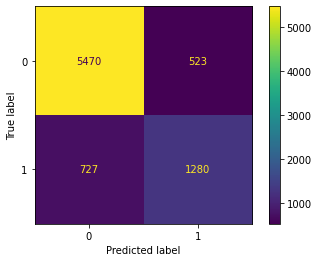

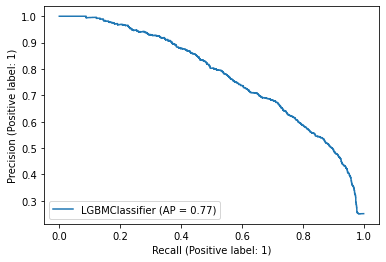

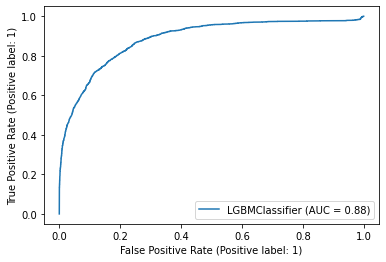

In [281]:
onehotcol1 = []
targ_col1 = ['zipcode','cap_gain_grp', 'cap_loss_grp','hours_group', 'gender','inquiry_purpose_code', 'marital_status', 'relationship', 'education_level','institute_type', 'account_type', 'asset_class_cd', 'workclass', 'asset_code', 'portfolio_type']

x, encoder = target_encoding(df_train[targ_col1])
x_test_main = encoder.transform(df_test[targ_col1])

x['Age'] = sc.fit_transform(df_train['Age'].to_numpy().reshape((-1,1)))
x_test_main['Age'] = pd.DataFrame(sc.transform(df_test['Age'].to_numpy().reshape((-1,1))))

y = df_train['approved']
y_test_main = df_test['approved']

models(x,y,x_test_main,y_test_main)




 
 FOR LIGHT GBM
roc_auc_score for training is 0.864532722035078
precision for training is 0.8161919831223629 
 Recall for training is 0.7868310664802339 
 f1_score is 0.8012426380169568
roc_auc_score for test is 0.734444669752978 
 precision for test is 0.654639175257732 
 recall for test is 0.5695067264573991 
 f1_score is 0.6091127098321343


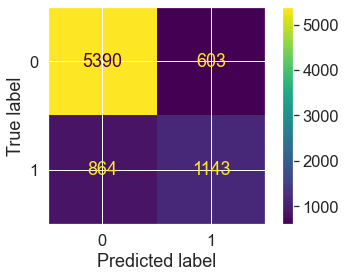

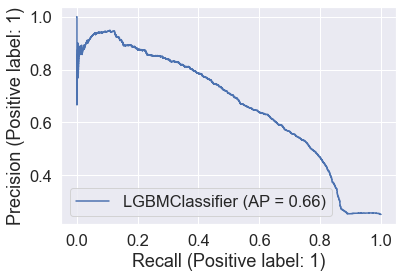

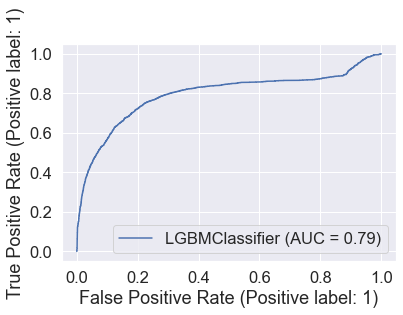

In [346]:
targ_col1 = ['city','email_domain','zipcode','cap_gain_grp', 'cap_loss_grp','hours_group', 'gender','inquiry_purpose_code', 'marital_status', 'relationship', 'education_level','institute_type', 'account_type', 'asset_class_cd', 'workclass', 'asset_code', 'portfolio_type']

x, encoder = target_encoding(df_train[targ_col1])
x_test_main = encoder.transform(df_test[targ_col1])

x['Age'] = sc.fit_transform(df_train['Age'].to_numpy().reshape((-1,1)))
x_test_main['Age'] = pd.DataFrame(sc.transform(df_test['Age'].to_numpy().reshape((-1,1))))

y = df_train['approved']
y_test_main = df_test['approved']

models(x,y,x_test_main,y_test_main)

# Model 6

* Removing city, email, ipcode and one hot encoding cap_gain_grp, cap_loss grop, and also adding net cap_gain\

1. Auc-roc: 80
2. precision: 71
3. recall: 66



 
 FOR LIGHT GBM
roc_auc_score for training is 0.8013540116663971
precision for training is 0.7747374648720603 
 Recall for training is 0.665819244947248 
 f1_score is 0.716160787530763
roc_auc_score for test is 0.8010410085641353 
 precision for test is 0.7708213670304422 
 recall for test is 0.6686596910812157 
 f1_score is 0.7161152614727855


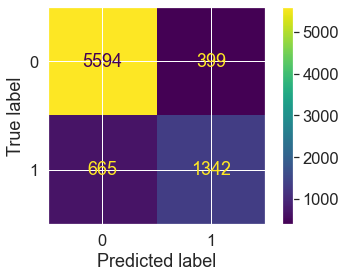

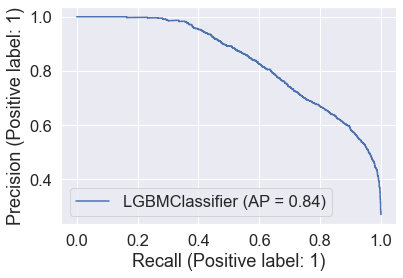

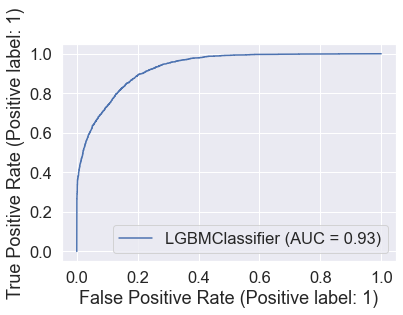

In [339]:
targ_col1 = ['state','net_cap_gain','hours_group','age_group', 'gender','inquiry_purpose_code', 'marital_status', 'relationship', 'education_level','institute_type', 'workclass']
one_hot_col1 = ['cap_gain_grp','cap_loss_grp']

x1, encoder1 = target_encoding(df_train[targ_col1])
x1_test_main1 = encoder1.transform(df_test[targ_col1])

x2, x2_test_main2 = one_hot_encoding(one_hot_col1)

x = x1.join(x2)
x_test_main = x1_test_main1.join(x2_test_main2)

y = df_train['approved']
y_test_main = df_test['approved']

models(x,y,x_test_main,y_test_main)

# Final model

## Adding incomes and checking permutations of various models

1. Taking different combinations of coloumns for label, One hot and target 
2. Trying additional features developed

* AUC_ROC: 81.5
* Precision: 77.5
* Recall: 69.5

1. Label encoded: Hours group, gender
2. Target: Age, Occupation,, edu_group,, inquiry purpose code, asset_code, account_type, relationship, marital status, workclass
3. No changes: husb_or_wife, net_cap_gain


[11:57:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:57:21] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' t

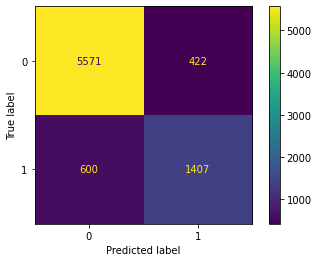

roc_auc_score for test is 0.8153154265427254 
 precision for test is 0.7692728266812466 
 recall for test is 0.7010463378176383 
 f1_score is 0.7335766423357665

 
 FOR LIGHT GBM
roc_auc_score for training is 0.80941285895247
precision for training is 0.786482108673244 
 Recall for training is 0.6789119105122664 
 f1_score is 0.7287488061127029
roc_auc_score for test is 0.8144927594068184 
 precision for test is 0.7765425236242357 
 recall for test is 0.6960637767812655 
 f1_score is 0.7341040462427746


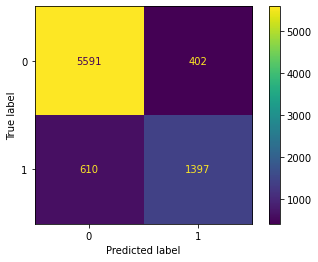

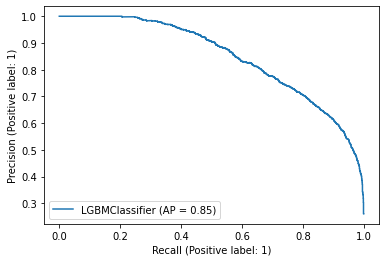

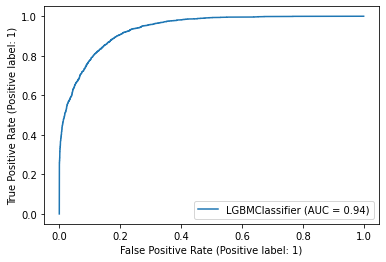

In [40]:
targ_col1 = ['account_type','edu_group','asset_code','institute_type', 'occupation','inquiry_purpose_code','relationship','marital_status','workclass']
label_col1 = ['gender']


# x2, x2_test_main2 =one_hot_encoding(['hours_group'])

x1, encoder1 = target_encoding(df_train[targ_col1])
x1_test_main1 = encoder1.transform(df_test[targ_col1])


x3, encoder3 = label_encoding(df_train[label_col1])
x3_test_main3 = encoder3.transform(df_test[label_col1])


x = x1.join(x3)
x_test_main = x1_test_main1.join(x3_test_main3)


x['husb_or_wife'] = df_train['husb_or_wife']
x_test_main['husb_or_wife'] = df_test['husb_or_wife']

x['hours_per_week'] = df_train['hours_per_week']
x_test_main['hours_per_week'] = df_test['hours_per_week']

x['income'] = df_train['net_income_occ_age_edu']
x_test_main['income'] = df_test['net_income_occ_age_edu']

x['net_cap_gain'] = df_train['net_cap_gain']
x_test_main['net_cap_gain'] = df_test['net_cap_gain']

x['Age'] = df_train['Age']
x_test_main['Age'] = df_test['Age']


y = df_train['approved']
y_test_main = df_test['approved']

models(x,y,x_test_main,y_test_main)

# pkl file

In [376]:
import pickle
filename = 'final_model.pkl'
pickle.dump(model_lgbm, open(filename, 'wb'))

